# Computing Cell Scores

With 5 indexes > 1x Final Score

Resolution - 1km

In [ ]:
pip install requests geopandas rasterio shapely numpy pandas pyproj fiona geopy geojson turfpy cupy cudf cuspatial

Create 1km x 1km grid from regional outline - sea.json

In [8]:
import geopandas as gpd
from shapely.geometry import box
import numpy as np
from tqdm import tqdm
import math

sea = gpd.read_file("data/sea.json").to_crs(epsg=3857) 


def create_grid(gdf, cell_size):
    minx, miny, maxx, maxy = gdf.total_bounds
    
    x_steps = math.ceil((maxx - minx) / cell_size)
    total_steps = x_steps
    print(f"Creating grid with approximately {total_steps} columns...")
    
    grid_cells = []
    # progress bar
    for x in tqdm(np.arange(minx, maxx, cell_size), desc="Creating grid"):
        for y in np.arange(miny, maxy, cell_size):
            cell = box(x, y, x + cell_size, y + cell_size)
            if gdf.unary_union.intersects(cell):
                grid_cells.append(cell)
    
    return gpd.GeoDataFrame(geometry=grid_cells, crs=gdf.crs)

grid = create_grid(sea, 10000)

print("Grid created with {} cells.".format(len(grid)))

grid.to_file("data/grid.json", driver="GeoJSON")

Creating grid with approximately 544 columns...


Creating grid:   0%|          | 0/544 [00:00<?, ?it/s]C:\Users\65963\AppData\Local\Temp\ipykernel_14832\1783126777.py:22: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  if gdf.unary_union.intersects(cell):
Creating grid: 100%|██████████| 544/544 [5:50:48<00:00, 38.69s/it]  


Grid created with 51875 cells.


## Load geojsons - except population

In [18]:
import geopandas as gpd
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

grid = gpd.read_file("data/grid.json")
grid = grid.to_crs("EPSG:4326")


def intersects_layer_with_dn(path, grid_geom_list):
    layer = gpd.read_file(path).to_crs(grid.crs)
    results = []
    for g in grid_geom_list:
        intersecting_features = layer[layer.intersects(g)]
        if not intersecting_features.empty:
            dn_avg = intersecting_features["DN"].mean()
            results.append(dn_avg if not np.isnan(dn_avg) else 0) 
        else:
            results.append(0) 
    return results

def centroid_dist_to_layer(path, grid_geom_list):
    coast = gpd.read_file(path).to_crs(grid.crs)
    return [coast.distance(g.centroid).min() for g in grid_geom_list]

def count_within(path, grid_geom_list):
    points = gpd.read_file(path).to_crs(grid.crs)
    return [points.within(g).sum() for g in grid_geom_list]

# Prepare tasks
tasks = {
    "gdp":     (intersects_layer_with_dn, "data/testData/spatgdp.geojson"),
    "amphibians": (intersects_layer_with_dn, "data/amphibians_vect.geojson"),
    "birds":      (intersects_layer_with_dn, "data/birds_vect.geojson"),
    "mammals":    (intersects_layer_with_dn, "data/mammals_vect1.geojson"),
    "humidity":   (intersects_layer_with_dn, "data/avgHU_vect.geojson"),
    "forest_cover": (intersects_layer_with_dn, "data/sea_forest_vect.geojson"),
    "dist_to_coast": (centroid_dist_to_layer, "data/earth-coastlines.geo.json"),
    "quake_count":   (count_within, "data/worldQuakesMiles.json"),
}

grid_geom_list = list(grid.geometry)

print(f"Processing {len(tasks)} spatial operations on {len(grid_geom_list)} grid cells...")

results = {}
for name, (func, path) in tqdm(tasks.items(), desc="Processing tasks", unit="task"):
    try:
        if path is None:
            results[name] = list(tqdm(func(grid_geom_list), desc=f"Processing {name}", leave=False))
        else:
            results[name] = list(tqdm(func(path, grid_geom_list), desc=f"Processing {name}", leave=False))
        print(f"{name.replace('_', ' ').capitalize()} values added to grid.")
    except Exception as e:
        print(f"Error processing {name}: {e}")

for k, v in results.items():
    grid[k] = v

grid.to_file("grid_vect.geojson", driver="GeoJSON")
print("✓ All vector data processed and saved to grid_vect.geojson")


Processing 8 spatial operations on 51875 grid cells...


Processing tasks:   0%|          | 0/8 [00:00<?, ?task/s]

Processing gdp:   0%|          | 0/51875 [00:00<?, ?it/s]

Gdp values added to grid.


Processing amphibians:   0%|          | 0/51875 [00:00<?, ?it/s]

Amphibians values added to grid.


Processing birds:   0%|          | 0/51875 [00:00<?, ?it/s]

Birds values added to grid.


Processing mammals:   0%|          | 0/51875 [00:00<?, ?it/s]

Mammals values added to grid.


Processing humidity:   0%|          | 0/51875 [00:00<?, ?it/s]

Humidity values added to grid.


Processing forest_cover:   0%|          | 0/51875 [00:00<?, ?it/s]

Forest cover values added to grid.


C:\Users\65963\AppData\Local\Temp\ipykernel_14832\3853064043.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return [coast.distance(g.centroid).min() for g in grid_geom_list]


Processing dist_to_coast:   0%|          | 0/51875 [00:00<?, ?it/s]

Dist to coast values added to grid.


Processing quake_count:   0%|          | 0/51875 [00:00<?, ?it/s]

Quake count values added to grid.
✓ All vector data processed and saved to grid_vect.geojson


## Load Population -failed

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

grid = gpd.read_file("grid_vect.geojson")
grid = grid.to_crs("EPSG:4326")

def intersects_layer_with_dn(path, grid_geom_list):
    layer = gpd.read_file(path).to_crs(grid.crs)
    results = []
    for g in grid_geom_list:
        intersecting_features = layer[layer.intersects(g)]
        if not intersecting_features.empty:
            dn_avg = intersecting_features["DN"].mean()
            results.append(dn_avg if not np.isnan(dn_avg) else 0)  
        else:
            results.append(0) 
    return results

tasks = {
    "vn": (intersects_layer_with_dn, "data/spatpop/vn.geojson"),
    "tl": (intersects_layer_with_dn, "data/spatpop/tl.geojson"),
    "th": (intersects_layer_with_dn, "data/spatpop/th.geojson"),
    "sg": (intersects_layer_with_dn, "data/spatpop/sg.geojson"),
    "pw": (intersects_layer_with_dn, "data/spatpop/pw.geojson"),
    "ph": (intersects_layer_with_dn, "data/spatpop/ph.geojson"),
    "my": (intersects_layer_with_dn, "data/spatpop/my.geojson"),
    "mm": (intersects_layer_with_dn, "data/spatpop/mm.geojson"),
    "la": (intersects_layer_with_dn, "data/spatpop/la.geojson"),
    "kh": (intersects_layer_with_dn, "data/spatpop/kh.geojson"),
    "id": (intersects_layer_with_dn, "data/spatpop/id.geojson"),
    "bn": (intersects_layer_with_dn, "data/spatpop/bn.geojson"),
}

grid_geom_list = list(grid.geometry)

print(f"Processing {len(tasks)} spatial operations on {len(grid_geom_list)} grid cells...")

results = {}
with tqdm(total=len(tasks), desc="Overall Progress", unit="task") as overall_pbar:
    for name, (func, path) in tasks.items():
        try:
            with tqdm(total=len(grid_geom_list), desc=f"Processing {name}", leave=False, unit="cell") as task_pbar:
                results[name] = []
                for g in grid_geom_list:
                    results[name].append(func(path, [g])[0])
                    task_pbar.update(1)
            print(f"{name.upper()} values calculated.")
        except Exception as e:
            print(f"Error processing {name}: {e}")
        overall_pbar.update(1)

# reverse values
for name in tasks.keys():
    grid[name] = 256 - results[name]

grid.to_file("grid_vect+pop.geojson", driver="GeoJSON")
print("✓ All vector data processed and saved to grid_vect+pop.geojson")


Adding population is too computationally heavy, we'll try running calculations directly by fetching from each geojson - take each grid from grid_vect.geojson and calculate indexes for that grid, add new column for each index

## Calculate Indexes

- Tsunami Risk Index
- Structure Durability Index
- Environmental Impact Index
- Operability Index
- Population-Economic Importance Index

In [1]:
import requests
import json
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, shape
from geopy.distance import geodesic
import math
from tqdm.auto import tqdm


In [2]:
mapbox_token = 'pk.eyJ1IjoiZGV4dWFudCIsImEiOiJjbTlpNzdxZGswZDlsMmlwcmIzOWhrOGlzIn0.4-M0wnkyIrx9itmQEQ8Jxw'

# pk.eyJ1IjoiZGV4dWFudCIsImEiOiJjbTlpNzdxZGswZDlsMmlwcmIzOWhrOGlzIn0.4-M0wnkyIrx9itmQEQ8Jxw - backup polimi

# pk.eyJ1IjoieHVhbngxMTEiLCJhIjoiY201dWhwZ2diMTg3dTJrcHRrZGx0eXc4diJ9.6k2pJftWF7A8MMzcVbWshg - original parsons

## TSI

In [ ]:
# Elevation scoring
def get_elevation_at_point(coordinates):
    lon, lat = coordinates
    url = f"https://api.mapbox.com/v4/mapbox.mapbox-terrain-v2/tilequery/{lon},{lat}.json?layers=contour&limit=1&access_token={mapbox_token}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        if data['features']:
            elevation = abs(data['features'][0]['properties']['ele'])
            return elevation
    except Exception as e:
        print("Error fetching elevation data:", e)
    return 0

def get_elevation_score(coordinates):
    elevation = get_elevation_at_point(coordinates)
    if elevation < 0:
        return 0
    elif elevation < 10:
        return elevation / 30
    elif elevation <= 50:
        return 0.34 + ((elevation - 10) / 40) * 0.32
    else:
        return min(0.67 + ((elevation - 50) / 50) * 0.33, 1.0)

# Coastline score
def get_coastline_score(coordinates, coastline_geojson_path="data/earth-coastlines.geo.json"):
    coastlines = gpd.read_file(coastline_geojson_path)
    point = Point(coordinates)
    min_distance = float('inf')

    for geom in coastlines.geometry:
        if geom is not None:
            dist = point.distance(geom)
            dist_km = dist * 111  # approx conversion from degrees to km
            if dist_km < min_distance:
                min_distance = dist_km

    print(f"Distance to nearest coastline: {min_distance:.2f} km")

    if min_distance > 10:
        return min(0.67 + (min_distance - 10) * 0.033, 1.0)
    elif min_distance > 5:
        return 0.34 + (min_distance - 5) * 0.066
    else:
        return min_distance * 0.066

# Tsunami score
def get_tsunami_score(coordinates, tsunami_tsv_path="data/tsunami.tsv"):
    df = pd.read_csv(tsunami_tsv_path, sep='\t')
    count = 0
    for _, row in df.iterrows():
        try:
            tsunami_coord = (row['Latitude'], row['Longitude'])
            dist = geodesic((coordinates[1], coordinates[0]), tsunami_coord).km
            if dist <= 100:
                count += 1
        except:
            continue

    print(f"Tsunami Count within 100km: {count}")

    if count <= 5:
        return min(0.67 + (5 - count) * 0.066, 1.0)
    elif count <= 15:
        return 0.34 + (15 - count) * 0.033
    else:
        return max(0, 0.33 - (count - 15) * 0.033)

# Final TSI calculation
def invert_score(score):
    return 1.0 - score

def calculate_tsi(elevation_score, coastline_score, tsunami_score):
    return 0.2 * elevation_score + 0.4 * coastline_score + 0.4 * invert_score(tsunami_score)

# test siem reap
# coordinates = (103.8509, 13.3671)  # Siem Reap
# coastline_geojson = 'data/earth-coastlines.geo.json'
# tsunami_tsv = 'data/tsunami.tsv'

# elevation_score = get_elevation_score(coordinates)
# coastline_score = get_coastline_score(coordinates, coastline_geojson)
# tsunami_score = get_tsunami_score(coordinates, tsunami_tsv)
# tsi = calculate_tsi(elevation_score, coastline_score, tsunami_score)

# print(f"TSI for coordinates {coordinates}: {tsi:.2f}")


# Add TSI calculation for each grid cell
grid = gpd.read_file("grid_vect.geojson")
grid = grid.to_crs("EPSG:4326")

# Initialize a list to store TSI values
tsi_values = []

# Iterate over each grid cell
for idx, row in tqdm(grid.iterrows(), total=len(grid), desc="Calculating TSI"):
    # Get the centroid of the grid cell as the representative point
    centroid = row.geometry.centroid
    coordinates = (centroid.x, centroid.y)
    
    # Calculate individual scores
    elevation_score = get_elevation_score(coordinates)
    coastline_score = get_coastline_score(coordinates)
    tsunami_score = get_tsunami_score(coordinates)
    
    # Calculate TSI
    tsi = calculate_tsi(elevation_score, coastline_score, tsunami_score)
    tsi_values.append(tsi)

    # Print progress for debugging
    print(f"Grid {idx}: TSI={tsi:.2f}")

# Add TSI values as a new column to the grid
grid['TSI'] = tsi_values

# Save the updated grid to a new GeoJSON file
grid.to_file("grid_vect_with_tsi.geojson", driver="GeoJSON")
print("✓ TSI values calculated and saved to grid_vect_with_tsi.geojson")

## SDI

In [5]:
# Elevation scoring
def get_elevation_at_point(coordinates):
    lon, lat = coordinates
    url = f"https://api.mapbox.com/v4/mapbox.mapbox-terrain-v2/tilequery/{lon},{lat}.json?layers=contour&limit=1&access_token={mapbox_token}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        if data['features']:
            elevation = abs(data['features'][0]['properties']['ele'])
            return elevation
    except Exception as e:
        print("Error fetching elevation data:", e)
    return 0

def get_elevation_score(coordinates):
    elevation = get_elevation_at_point(coordinates)
    if elevation < 0:
        return 0
    elif elevation < 10:
        return elevation / 30
    elif elevation <= 50:
        return 0.34 + ((elevation - 10) / 40) * 0.32
    else:
        return min(0.67 + ((elevation - 50) / 50) * 0.33, 1.0)

In [6]:
def get_coastline_score(coordinates, coastline_geojson_path="data/earth-coastlines.geo.json"):
    coastlines = gpd.read_file(coastline_geojson_path)
    point = Point(coordinates)
    min_distance = float('inf')

    for geom in coastlines.geometry:
        if geom is not None:
            dist = point.distance(geom)
            dist_km = dist * 111  # approx conversion from degrees to km
            if dist_km < min_distance:
                min_distance = dist_km

    print(f"Distance to nearest coastline: {min_distance:.2f} km")

    if min_distance > 10:
        return min(0.67 + (min_distance - 10) * 0.033, 1.0)
    elif min_distance > 5:
        return 0.34 + (min_distance - 5) * 0.066
    else:
        return min_distance * 0.066

In [17]:
def invert_score(score):
    return 1.0 - score

In [ ]:
import geopandas as gpd
import json
from geopy.distance import geodesic
from shapely.geometry import shape, Point, Polygon, MultiPolygon

# Seismic score
def get_seismic_score(coordinates, earthquake_geojson_path="data/worldQuakesMiles.json"):
    with open(earthquake_geojson_path, 'r', encoding='utf-8') as f:
        earthquake_data = json.load(f)

    point = Point(coordinates)
    min_distance = float('inf')

    for feature in earthquake_data['features']:
        quake_coords = feature['geometry']['coordinates'][:2]
        quake_point = (quake_coords[1], quake_coords[0])  # (lat, lon)
        dist = geodesic((coordinates[1], coordinates[0]), quake_point).km
        if dist <= 150 and dist < min_distance:
            min_distance = dist

    print(f"Minimum Distance to Earthquake: {min_distance:.2f} km")

    if min_distance > 150:
        return min(0.67 + (min_distance - 150) * 0.0022, 1.0)
    elif min_distance > 50:
        return 0.34 + (min_distance - 50) * 0.0033
    else:
        return max(0, 0.33 - (50 - min_distance) * 0.0066)

# Humidity score
def get_humidity_score(coordinates, humidity_geojson_path="data/avgHU_vect.geojson"):
    with open(humidity_geojson_path, 'r', encoding='utf-8') as f:
        humidity_data = json.load(f)

    point = Point(coordinates)
    humidity_value = None

    for feature in humidity_data['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            humidity_value = feature['properties'].get('DN')
            break

    if humidity_value is None:
        print("Point is not within any polygon.")
        return 0.0

    print(f"Humidity Value: {humidity_value}")
    humidity_score = 1.0 - humidity_value / 255.0
    print(f"Humidity Score: {humidity_score:.2f}")
    return humidity_score

def calculate_sdi(seismic_score, elevation_score, coastline_score, humidity_score):
    return (
        0.4 * seismic_score +
        0.25 * elevation_score +
        0.2 * coastline_score +
        0.15 * invert_score(humidity_score)
    )

# Test hanoi
# coordinates = (105.8342, 21.0278)  # Hanoi
# earthquake_json = 'data/worldQuakesMiles.json'
# humidity_geojson = 'data/avgHU_vect.geojson'
# coastline_geojson = 'data/earth-coastlines.geo.json'
# tsunami_tsv = 'data/tsunami.tsv'

# elevation_score = get_elevation_score(coordinates)
# coastline_score = get_coastline_score(coordinates, coastline_geojson)
# seismic_score = get_seismic_score(coordinates, earthquake_json)
# humidity_score = get_humidity_score(coordinates, humidity_geojson)
# sdi = calculate_sdi(seismic_score, elevation_score, coastline_score, humidity_score)

# print(f"SDI for coordinates {coordinates}: {sdi:.2f}")


# SDI calculation for each grid
grid = gpd.read_file("grid_vect_tsi_pei.geojson") 
grid = grid.to_crs("EPSG:4326")

sdi_values = []

for idx, row in tqdm(grid.iterrows(), total=len(grid), desc="Calculating SDI"):
    centroid = row.geometry.centroid
    coordinates = (centroid.x, centroid.y)
    
    elevation_score = get_elevation_score(coordinates)
    coastline_score = get_coastline_score(coordinates)
    seismic_score = get_seismic_score(coordinates)
    humidity_score = get_humidity_score(coordinates)
    
    sdi = calculate_sdi(seismic_score, elevation_score, coastline_score, humidity_score)
    sdi_values.append(sdi)

    print(f"Grid {idx}: SDI={sdi:.2f}")

grid['SDI'] = sdi_values

grid.to_file("grid_vect_tsi_pei_sdi.geojson", driver="GeoJSON")
print("✓ SDI values calculated and saved to grid_vect_tsi_pei_sdi.geojson")

## E2I

In [ ]:
import geopandas as gpd
import numpy as np
from tqdm.auto import tqdm

def calculate_species_score(file_path, grid):
    species_data = gpd.read_file(file_path).to_crs(grid.crs)
    species_scores = []

    for grid_cell in tqdm(grid.geometry, desc=f"Processing {file_path}", leave=False):
        intersecting_features = species_data[species_data.intersects(grid_cell)]
        if not intersecting_features.empty:
            avg_dn = intersecting_features["DN"].mean()
            # Normalize DN value to 0–1
            normalized_dn = avg_dn / 255.0
            # Invert the score (higher DN = higher density = lower score)
            score = 1.0 - normalized_dn
            species_scores.append(score if not np.isnan(score) else 1.0)
        else:
            species_scores.append(1.0)  # Default score if no intersection

    return species_scores

def calculate_combined_biodiversity_score(grid):
    mammals_score = calculate_species_score("data/mammals_vect1.geojson", grid)
    birds_score = calculate_species_score("data/birds_vect.geojson", grid)
    amphibians_score = calculate_species_score("data/amphibians_vect.geojson", grid)

    # Combine the scores by averaging them
    combined_score = np.mean([mammals_score, birds_score, amphibians_score], axis=0)

    return combined_score

grid = gpd.read_file("grid_vect_tsi_pei_sdi.geojson") 
grid = grid.to_crs("EPSG:4326")

print("Calculating E2I values...")
e2i_values = calculate_combined_biodiversity_score(grid)

grid["E2I"] = e2i_values

for idx, row in tqdm(grid.iterrows(), total=len(grid), desc="Saving E2I values"):
    print(f"Grid {idx}: E2I = {row['E2I']:.2f}")

grid.to_file("grid_vect_tsi_pei_sdi_e2i.geojson", driver="GeoJSON")
print("✓ E2I values calculated and saved to grid_vect_tsi_pei_sdi_e2i.geojson")

## OPI

In [3]:
def intersects_layer_with_dn(path, grid_geom_list):
    layer = gpd.read_file(path).to_crs(grid.crs)
    results = []
    for g in grid_geom_list:
        intersecting_features = layer[layer.intersects(g)]
        if not intersecting_features.empty:
            dn_avg = intersecting_features["DN"].mean()
            results.append(dn_avg if not np.isnan(dn_avg) else 0) 
        else:
            results.append(0) 
    return results

def get_elevation_at_point(coordinates):
    lon, lat = coordinates
    url = f"https://api.mapbox.com/v4/mapbox.mapbox-terrain-v2/tilequery/{lon},{lat}.json?layers=contour&limit=1&access_token={mapbox_token}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        if data['features']:
            elevation = abs(data['features'][0]['properties']['ele'])
            return elevation
    except Exception as e:
        print("Error fetching elevation data:", e)
    return 0

def get_elevation_score(coordinates):
    elevation = get_elevation_at_point(coordinates)
    if elevation < 0:
        return 0
    elif elevation < 10:
        return elevation / 30
    elif elevation <= 50:
        return 0.34 + ((elevation - 10) / 40) * 0.32
    else:
        return min(0.67 + ((elevation - 50) / 50) * 0.33, 1.0)

spatpop_countries = {
    "vn": (intersects_layer_with_dn, "data/spatpop/vn.geojson"),
    "tl": (intersects_layer_with_dn, "data/spatpop/tl.geojson"),
    "th": (intersects_layer_with_dn, "data/spatpop/th.geojson"),
    "sg": (intersects_layer_with_dn, "data/spatpop/sg.geojson"),
    "pw": (intersects_layer_with_dn, "data/spatpop/pw.geojson"),
    "ph": (intersects_layer_with_dn, "data/spatpop/ph.geojson"),
    "my": (intersects_layer_with_dn, "data/spatpop/my.geojson"),
    "mm": (intersects_layer_with_dn, "data/spatpop/mm.geojson"),
    "la": (intersects_layer_with_dn, "data/spatpop/la.geojson"),
    "kh": (intersects_layer_with_dn, "data/spatpop/kh.geojson"),
    "id": (intersects_layer_with_dn, "data/spatpop/id.geojson"),
    "bn": (intersects_layer_with_dn, "data/spatpop/bn.geojson"),
}

In [6]:
import asyncio
import aiohttp
import math
import numpy as np
from turfpy.measurement import distance
from geojson import Point
from PIL import Image
from io import BytesIO
import requests


def compute_network_score(density):
    if density > 5:
        return max(0.33 - (density - 5) * 0.033, 0)
    elif density > 1:
        return 0.34 + (5 - density) * 0.066
    else:
        return min(0.67 + (1 - density) * 0.33, 1.0)


async def get_network_density_score(coordinates, radius_km=0.5):
    lat, lon = coordinates[1], coordinates[0]
    query = f"""
    [out:json][timeout:25];
    (
      way["highway"](around:{radius_km * 1000},{lat},{lon});
      way["railway"](around:{radius_km * 1000},{lat},{lon});
    );
    out geom qt 500;
    """
    url = f"https://overpass-api.de/api/interpreter?data={requests.utils.quote(query)}"
    async with aiohttp.ClientSession() as session:
        async with session.get(url) as resp:
            data = await resp.json()
    
    total_length = 0
    for el in data.get("elements", []):
        coords = [(pt["lon"], pt["lat"]) for pt in el.get("geometry", [])]
        if len(coords) < 2:
            continue
        segment_length = 0
        for i in range(1, len(coords)):
            pt1, pt2 = Point(coords[i-1]), Point(coords[i])
            segment_length += distance(pt1, pt2, units="km")
        total_length += segment_length
    
    area_km2 = math.pi * radius_km ** 2
    density = total_length / area_km2
    return compute_network_score(density)


def get_urban_proximity_score(coordinates, major_centers):
    pt = Point(coordinates)
    min_dist = min(distance(pt, Point(center), units="km") for center in major_centers)

    if min_dist < 15:
        return min(0.67 + ((15 - min_dist) / 15) * 0.33, 1.0)
    elif min_dist <= 50:
        return 0.34 + ((50 - min_dist) / 35) * 0.33
    else:
        return max(0, 0.33 - ((min_dist - 50) / 50) * 0.33)


def get_population_count_from_rgb(r, g, b):
    brightness = (r * 299 + g * 587 + b * 114) / 1000
    if brightness < 100:
        return 0
    elif brightness < 150:
        return 35
    elif brightness < 200:
        return 50
    elif brightness < 250:
        return 85
    else:
        return 110
    

def get_population_estimate_from_dn(dn_value):
    if dn_value == 0:
        return 0 
    
    # after inversion, higher values = denser pop
    inverted_dn = 256 - dn_value
    
    if inverted_dn >= 240:  # Megacities (Jakarta, Manila, Singapore)
        return 15000 + (inverted_dn - 240) * (10000/15)  # 15,000-25,000 people/km²
    elif inverted_dn >= 200:  # Major urban centers (Bangkok, Ho Chi Minh)
        return 5000 + (inverted_dn - 200) * (10000/40)   # 5,000-15,000 people/km²
    elif inverted_dn >= 150:  # Secondary cities and suburbs
        return 1000 + (inverted_dn - 150) * (4000/50)    # 1,000-5,000 people/km²
    elif inverted_dn >= 100:  # Towns and dense rural areas
        return 300 + (inverted_dn - 100) * (700/50)      # 300-1,000 people/km²
    elif inverted_dn >= 50:   # Rural villages
        return 50 + (inverted_dn - 50) * (250/50)        # 50-300 people/km²
    else:                     # Very sparse rural, mountains, forests
        return inverted_dn                               # 1-50 people/km²

def get_population_density_score(grid_cell, radius_km=0.5):
    area_km2 = grid_cell.geometry.area / 1000000  # Convert m² to km²
    if area_km2 <= 0:
        area_km2 = math.pi * (radius_km ** 2)  # Fallback area
    
    spatpop_countries = ["vn", "tl", "th", "sg", "pw", "ph", "my", "mm", "la", "kh", "id", "bn"]
    
    max_population = 0
    for country_code in spatpop_countries:
        if country_code in grid_cell and grid_cell[country_code] > 0:
            dn_value = grid_cell[country_code]
            pop_estimate = get_population_estimate_from_dn(dn_value)
            max_population = max(max_population, pop_estimate)
    
    if max_population == 0:
        r = int(min(grid_cell.humidity if 'humidity' in grid_cell else 128, 255))
        g = int(min(grid_cell.forest_cover if 'forest_cover' in grid_cell else 128, 255))
        b = int(min(grid_cell.gdp if 'gdp' in grid_cell else 128, 255))
        pop_count = get_population_count_from_rgb(r, g, b)
        max_population = pop_count
    
    pop_density = max_population
    
    if pop_density < 500:
        return (pop_density / 500) * 0.33
    elif pop_density <= 5000:
        return 0.34 + ((pop_density - 500) / 4500) * 0.32
    else:
        return min(0.67 + ((pop_density - 5000) / 5000) * 0.33, 1.0)
    

    # Test with Jakarta
    #jakarta = [106.8456, -6.2088]
    #major_cities = [
    #    [106.6297, 10.8231],  # Ho Chi Minh
    #    [100.5018, 13.7563],  # Bangkok
    #    [106.8456, -6.2088],  # Jakarta
    #    [120.9842, 14.5995],  # Manila
    #    [104.8885, 11.5564],  # Phnom Penh
    #]

    #async def test_jakarta():
    #    elev = await get_elevation_score(jakarta)
    #    net = await get_network_density_score(jakarta)
    #    urban = get_urban_proximity_score(jakarta, major_cities)
    #    pop = get_population_density_score_from_image("https://api.mapbox.com/v4/xuanx111.520thek8/12/3462/2331@2x.pngraw?access_token=YOUR_MAPBOX_ACCESS_TOKEN")
        
    #    opi = calculate_opi(elev, net, urban, pop)
    #    print(f"Jakarta - OPI: {opi}, Elev: {elev:.2f}, Net: {net:.2f}, Urban: {urban:.2f}, Pop: {pop:.2f}")

    #await test_jakarta()




# major urban centers in Southeast Asia
major_cities = [
[106.6297, 10.8231],  # Ho Chi Minh City, Vietnam
    [100.5018, 13.7563],  # Bangkok, Thailand
    [106.8456, -6.2088],  # Jakarta, Indonesia
    [120.9842, 14.5995],  # Manila, Philippines
    [104.8885, 11.5564],  # Phnom Penh, Cambodia
    [103.8198, 1.3521],   # Singapore
    [105.8342, 21.0278],  # Hanoi, Vietnam
    [101.6869, 3.1390],   # Kuala Lumpur, Malaysia
    [98.6722, 3.5952],    # Medan, Indonesia
    [115.2167, -8.6500],  # Denpasar, Indonesia
    [96.1950, 16.8700],   # Yangon, Myanmar
    [102.5951, 17.9512],  # Vientiane, Laos
    
    # Indonesia
    [112.7501, -7.2575],  # Surabaya
    [107.6191, -6.9175],  # Bandung
    [110.3695, -7.7956],  # Yogyakarta
    [110.4203, -6.9932],  # Semarang
    [104.0464, 1.1301],   # Batam
    [119.4320, -5.1477],  # Makassar
    [109.3425, -0.0263],  # Pontianak
    
    # Malaysia
    [100.3327, 5.4164],   # Penang/George Town
    [103.4279, 4.2498],   # Kuantan
    [103.3300, 3.8077],   # Kuala Terengganu
    [116.0753, 5.9750],   # Kota Kinabalu
    [110.3593, 1.5533],   # Kuching
    [113.9418, 4.3959],   # Miri
    [102.2386, 2.1944],   # Johor Bahru
    
    # Philippines
    [125.6127, 7.1907],   # Davao City
    [123.8854, 10.3157],  # Cebu City
    [124.6469, 8.4542],   # Cagayan de Oro
    [122.0574, 6.9108],   # Zamboanga City
    [123.3059, 9.3068],   # Bacolod
    [120.5960, 16.4023],  # Baguio
    
    # Vietnam
    [108.2772, 16.0678],  # Da Nang
    [109.1821, 12.2388],  # Nha Trang
    [108.4187, 11.9416],  # Da Lat
    [103.9612, 10.3465],  # Phu Quoc
    [107.0843, 10.3456],  # Vung Tau
    [105.7664, 10.0341],  # Can Tho
    [106.3318, 20.8449],  # Hai Phong
    
    # Thailand
    [98.9853, 18.7883],   # Chiang Mai
    [101.2500, 12.9306],  # Pattaya
    [98.3923, 7.8840],    # Phuket
    [100.8923, 12.9344],  # Chonburi
    [99.9576, 19.9071],   # Chiang Rai
    [102.8359, 16.4419],  # Khon Kaen
    [104.1178, 15.1141],  # Ubon Ratchathani
    
    # Myanmar
    [97.7428, 16.7834],   # Mawlamyine
    [94.9672, 21.1272],   # Sittwe
    [96.4887, 19.7633],   # Bagan
    [97.0237, 22.0088],   # Mandalay
    
    # Cambodia
    [103.5138, 13.3666],  # Siem Reap
    [103.8987, 13.4399],  # Battambang
    [103.5641, 10.6106],  # Sihanoukville
    
    # Laos
    [103.7340, 19.8847],  # Luang Prabang
    [105.7996, 15.1208],  # Savannakhet
    [101.4221, 19.4959],  # Houayxay
    
    # Brunei
    [114.9481, 4.9031],   # Bandar Seri Begawan
    [114.1900, 4.5834],   # Seria
    
    # Timor-Leste
    [125.5741, -8.5568],  # Dili
    [124.3683, -9.1998]   # Suai
   
]




def calculate_opi(elev, network, urban, pop):
    return round(
        0.24 * elev + 0.28 * network + 0.24 * urban + 0.24 * pop,
        2
    )

In [ ]:
import asyncio
from tqdm.auto import tqdm
import geopandas as gpd
import nest_asyncio
import time

# Allow nested event loops in Jupyter Notebook
nest_asyncio.apply()

grid = gpd.read_file("grid_vect_tsi_pei_sdi_e2i.geojson")
grid = grid.to_crs("EPSG:4326")

async def process_all_cells_with_retry():
    opi_values = []
    semaphore = asyncio.Semaphore(5)  # limit concurrent API calls

    async def process_with_semaphore(idx, row_data):
        async with semaphore:
            centroid = row_data.geometry.centroid
            coordinates = (centroid.x, centroid.y)
            
            elevation_score = get_elevation_score(coordinates)
            network_score = None
            retries = 5
            for attempt in range(retries):
                try:
                    network_score = await get_network_density_score(coordinates)
                    break
                except aiohttp.ClientResponseError as e:
                    if e.status == 429 and attempt < retries - 1:
                        wait_time = 2 ** attempt
                        print(f"Rate limit exceeded. Retrying in {wait_time} seconds...")
                        time.sleep(wait_time)
                    else:
                        print(f"Failed to fetch network density score for grid {idx}: {e}")
                        network_score = 0
                        break
            
            urban_score = get_urban_proximity_score(coordinates, major_cities)
            population_score = get_population_density_score(row_data)
            
            opi = calculate_opi(elevation_score, network_score, urban_score, population_score)
            print(f"Grid {idx}: OPI={opi:.2f}")
            return opi

    tasks = []
    for idx, row in grid.iterrows():
        tasks.append(process_with_semaphore(idx, row))

    for opi in tqdm(asyncio.as_completed(tasks), total=len(tasks), desc="Calculating OPI"):
        opi_values.append(await opi)

    return opi_values

opi_values = await process_all_cells_with_retry()

grid['OPI'] = opi_values

grid.to_file("grid_vect_tsi_pei_sdi_e2i_opi.geojson", driver="GeoJSON")
print("✓ OPI values calculated and saved to grid_vect_tsi_pei_sdi_e2i_opi.geojson")

## PEI

In [ ]:
import math
import json
import requests
from geojson import Point
from turfpy.measurement import boolean_point_in_polygon
from shapely.geometry import shape


def get_land_area(radius_km=0.5):
    area = math.pi * radius_km ** 2
    print(f"Land Area within {radius_km} km radius: {area:.2f} km²")
    return area

# Test Land Area for Medan
#medan_coords = [98.6722, 3.5952]
#land_area = get_land_area()
#print(f"Land Area for Medan: {land_area:.2f} km²")

def get_gdp_score(coordinates, geojson_path="data/testData/spatgdp.geojson"):
    with open(geojson_path) as f:
        gdp_data = json.load(f)
    
    pt = Point(coordinates)
    gdp_value = None

    for feature in gdp_data["features"]:
        polygon = shape(feature["geometry"])
        if polygon.contains(shape(pt)):
            gdp_value = feature["properties"]["DN"]
            break

    if gdp_value is None:
        print("Point is not within any polygon.")
        return 0.0

    print(f"GDP Value (DN): {gdp_value}")
    if gdp_value <= 47:
        return 1.0
    elif gdp_value <= 94:
        return 0.8
    elif gdp_value <= 141:
        return 0.6
    elif gdp_value <= 188:
        return 0.4
    else:
        return 0.2


# Test GDP Score
#kl_coords = [101.6869, 3.1390]
#medan_coords = [98.6722, 3.5952]

#gdp_kl = get_gdp_score(kl_coords)
#print(f"GDP Score for Kuala Lumpur: {gdp_kl:.2f}")

#gdp_medan = get_gdp_score(medan_coords)
#print(f"GDP Score for Medan: {gdp_medan:.2f}")


def calculate_pei(pop_density_score, gdp_score):
    pei = 0.6 * pop_density_score + 0.4 * gdp_score
    return round(pei, 2)
#test medan
#pop_score_medan = mock_population_density_score(medan_coords)
#pei_medan = calculate_pei(pop_score_medan, gdp_medan)
#print(f"PEI for Medan: {pei_medan:.2f}")



import geopandas as gpd
from tqdm.auto import tqdm
import math

grid = gpd.read_file("grid_vect_with_tsi.geojson")
grid = grid.to_crs("EPSG:4326")

pei_values = []

for idx, row in tqdm(grid.iterrows(), total=len(grid), desc="Calculating PEI"):
    centroid = row.geometry.centroid
    coordinates = (centroid.x, centroid.y)
    
    gdp_score = get_gdp_score(coordinates)
    
    pop_density_score = get_population_density_score(row)
    
    pei = calculate_pei(pop_density_score, gdp_score)
    pei_values.append(pei)
    
    print(f"Grid {idx}: PEI={pei:.2f}")

grid['PEI'] = pei_values

grid.to_file("grid_vect_tsi_pei.geojson", driver="GeoJSON")
print("✓ PEI values calculated and saved to grid_vect_tsi_opi.geojson")

## FFI - Final Feasibility Index


In [ ]:
def calculate_ffi(tsi, sdi, e2i, opi, pei):
    ffi = 0.2 * tsi + 0.2 * sdi + 0.15 * e2i + 0.25 * opi + 0.2 * pei
    print(f"Final Feasibility Index (FFI): {ffi:.2f}")
    return ffi


grid = gpd.read_file("grid_vect_tsi_pei_sdi_e2i_opi.geojson")
grid = grid.to_crs("EPSG:4326")


ffi_values = []

for idx, row in tqdm(grid.iterrows(), total=len(grid), desc="Calculating FFI"):
    tsi = row['TSI']
    sdi = row['SDI']
    e2i = row['E2I']
    opi = row['OPI']
    pei = row['PEI']
    
    ffi = calculate_ffi(tsi, sdi, e2i, opi, pei)
    ffi_values.append(ffi)
    
    if idx % 100 == 0 or idx == len(grid) - 1:
        print(f"Grid {idx}: FFI={ffi:.2f}")

grid['FFI'] = ffi_values

grid.to_file("grid_final.geojson", driver="GeoJSON")
print("✓ FFI values calculated and saved to grid_final.geojson")

## Visualisation

In [ ]:
import folium
from folium.plugins import HeatMap


grid = gpd.read_file("grid_vect_tsi_pei_sdi_e2i_opi.geojson")
grid = grid.to_crs("EPSG:4326")

min_ffi = grid["FFI"].min()
max_ffi = grid["FFI"].max()

heat_data = [[row.geometry.centroid.y, row.geometry.centroid.x, (row["FFI"] - min_ffi) / (max_ffi - min_ffi)]
             for _, row in grid.iterrows()]

# Create heatmap
map = folium.Map(location=[9, 115], zoom_start=5)
HeatMap(heat_data, radius=2, blur=2).add_to(map)

map
# map.save("ffi_heatmap.html")


Visualise with GeoPandas

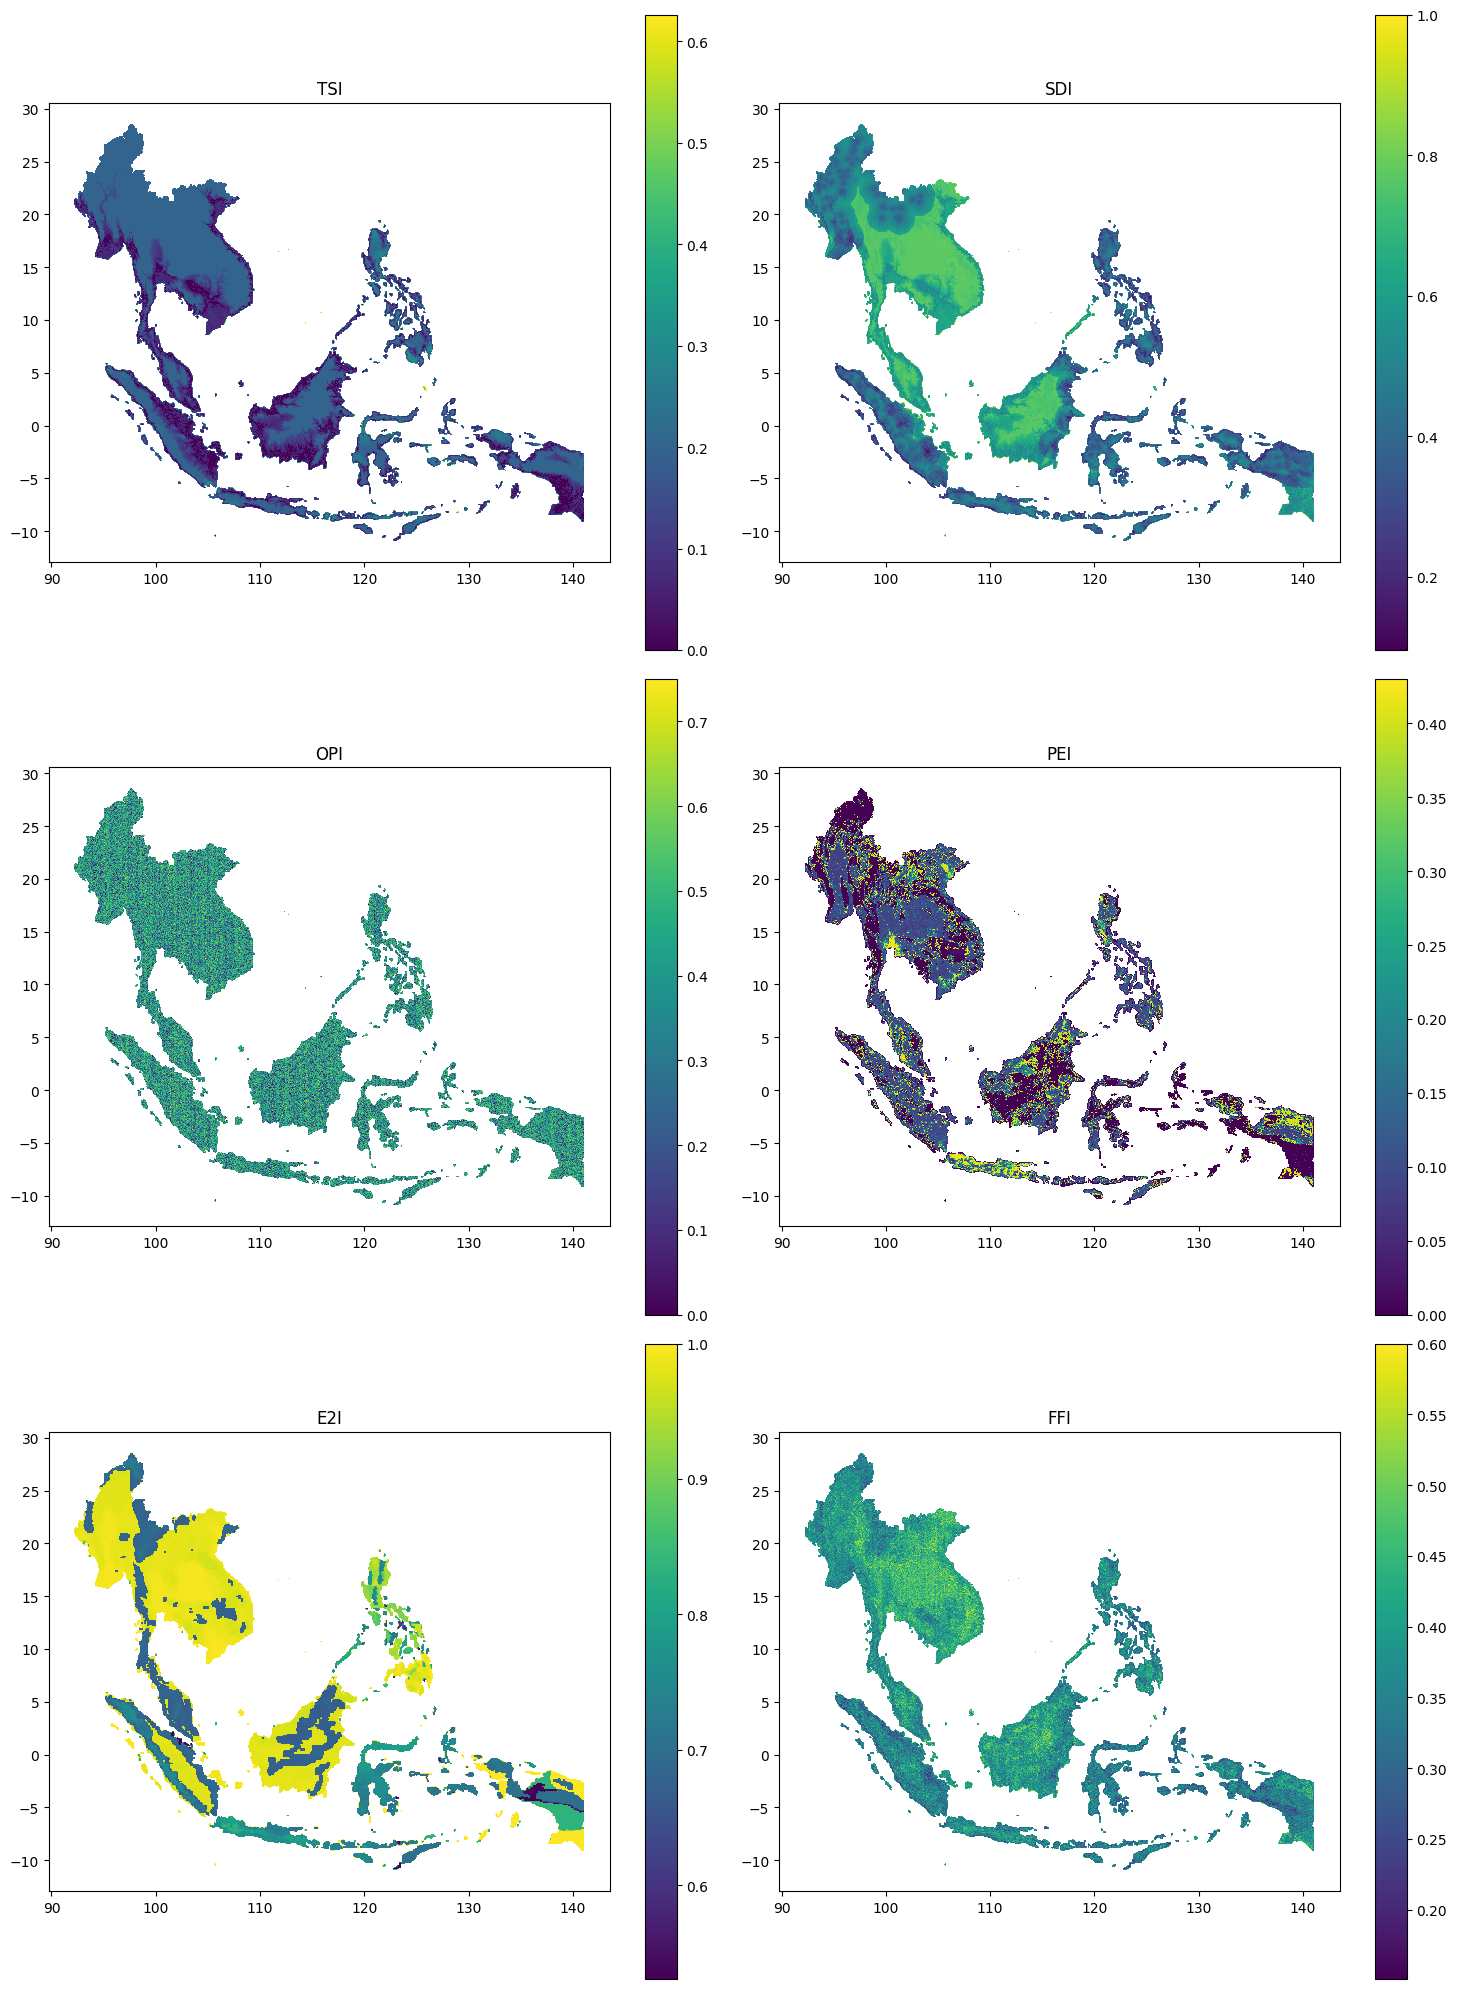

In [ ]:
import matplotlib.pyplot as plt


grid = gpd.read_file("grid_vect_tsi_pei_sdi_e2i_opi.geojson")
grid = grid.to_crs("EPSG:4326")

fig, axes = plt.subplots(3, 2, figsize=(15, 20))

grid.plot(column="TSI", cmap="viridis", legend=True, ax=axes[0, 0])
axes[0, 0].set_title("TSI")

grid.plot(column="SDI", cmap="viridis", legend=True, ax=axes[0, 1])
axes[0, 1].set_title("SDI")

grid.plot(column="OPI", cmap="viridis", legend=True, ax=axes[1, 0])
axes[1, 0].set_title("OPI")

grid.plot(column="PEI", cmap="viridis", legend=True, ax=axes[1, 1])
axes[1, 1].set_title("PEI")

grid.plot(column="E2I", cmap="viridis", legend=True, ax=axes[2, 0])
axes[2, 0].set_title("E2I")

grid.plot(column="FFI", cmap="viridis", legend=True, ax=axes[2, 1])
axes[2, 1].set_title("FFI")

plt.tight_layout()
plt.show()

In [ ]:
def suggestedRanges(grid, columns):
    ranges = {}
    for col in columns:
        min_val = grid[col].min()
        max_val = grid[col].max()
        mean_val = grid[col].mean()
        std_dev = grid[col].std()
        
        # Suggest range as mean ± 1 standard deviation
        suggested_min = max(min_val, mean_val - std_dev)
        suggested_max = min(max_val, mean_val + std_dev)
        
        ranges[col] = {
            "min": min_val,
            "max": max_val,
            "mean": mean_val,
            "std_dev": std_dev,
            "suggested_range": (suggested_min, suggested_max)
        }
    return ranges

columns_to_analyze = ['TSI', 'SDI', 'OPI', 'PEI', 'E2I', 'FFI']
ranges = suggestedRanges(grid, columns_to_analyze)

for col, stats in ranges.items():
    print(f"{col}:")
    print(f"  Min: {stats['min']:.2f}, Max: {stats['max']:.2f}")
    print(f"  Mean: {stats['mean']:.2f}, Std Dev: {stats['std_dev']:.2f}")
    print(f"  Suggested Range: {stats['suggested_range']}")

TSI:
  Min: 0.00, Max: 0.63
  Mean: 0.15, Std Dev: 0.08
  Suggested Range: (0.07011573163818859, 0.22844799878733907)
SDI:
  Min: 0.10, Max: 1.00
  Mean: 0.53, Std Dev: 0.16
  Suggested Range: (0.3695389158871749, 0.6922630019088656)
OPI:
  Min: 0.00, Max: 0.75
  Mean: 0.38, Std Dev: 0.14
  Suggested Range: (0.23905203299634178, 0.5255875814614897)
PEI:
  Min: 0.00, Max: 0.43
  Mean: 0.11, Std Dev: 0.13
  Suggested Range: (0.0, 0.24524538512642402)
E2I:
  Min: 0.53, Max: 1.00
  Mean: 0.87, Std Dev: 0.14
  Suggested Range: (0.7275184911004466, 1.0)
FFI:
  Min: 0.15, Max: 0.60
  Mean: 0.38, Std Dev: 0.06
  Suggested Range: (0.3207575967485207, 0.4476098086655386)
